<a href="https://colab.research.google.com/github/andysingal/mobile-classification/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Description

XYZ has started their own mobile company. They want to fight hard battles with big companies like Apple, Samsung, etc. In this competitive mobile market, you cannot simply imagine things. To solve this problem you are collecting data on mobile sales of various companies. They want to find some connection between mobile features (eg: - RAM, Internal Memory, etc.) and their sales value. But they are not very good at Machine Learning. So they need your help to solve this problem. In this case, you do not need to predict the actual price but a price list that shows how high the price is.

##Data Description

The data is divided into 2 groups:
• Training Set (train.csv) 
• Test Set (test.csv) 
The training set should be used to build learning models for your machine. In the training set, we provide the result (also known as a target label or class) for each mobile data point. A test set should be used to see how well your model is performing on intangible data. In the test set, we do not provide the result (targeted variable) of each mobile data point of sale. For each data point in the test, use a trained model to predict the price range.


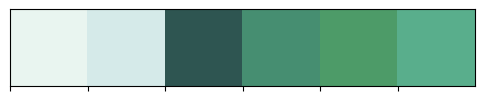

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px 

# Pandas Profiling
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

#color pallet and theme
import matplotlib.colors

colors = ["#e9f5f0","#d5eae9","#2e5551",'#468e71','#4d9b68','#59ae8c']
colors2 = ["#2e5551",'#468e71','#4d9b68','#59ae8c', "#e9f5f0","#d5eae9"]
cmap = matplotlib.colors.ListedColormap(colors2)

sns.palplot(sns.color_palette(colors))


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

#TEST DATA

In [3]:
DATA_FIL = 'mobile-price-classification/test.csv'
df_test = pd.read_csv(DATA_FIL)
#Drop Redundant column 
df_test = df_test.loc[:, df_test.columns!='Unnamed: 0']
df_test = df_test.rename(columns = {'blue': 'Bluetooth',
                          'battery_power': 'Battery_power',
                          'clock_speed': 'Clock_speed',
                          'dual_sim': 'Dual_sim',
                          'four_g': '4G_Network',
                          'int_memory':'Internal_memory',
                          "m_dep": "depth",
                          "mobile_wt": "weight",
                          "pc": "primary_camera_megapixels",
                          'n_cores': 'Number_of_processor_cores',
                          'px_height':'Pixel_Resolution_Height',
                          'px_width': 'Pixel_Resolution_Width',
                          "fc": "front_camera_megapixels",
                          "sc_h": "screen_height",
                          "sc_w": "screen_width",
                          "three_g": "3G_Network",
})
df_test= df_test.reset_index(drop=True)
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Battery_power              500 non-null    int64  
 1   Bluetooth                  500 non-null    int64  
 2   Clock_speed                500 non-null    float64
 3   Dual_sim                   500 non-null    int64  
 4   front_camera_megapixels    500 non-null    int64  
 5   4G_Network                 500 non-null    int64  
 6   Internal_memory            500 non-null    int64  
 7   depth                      500 non-null    float64
 8   weight                     500 non-null    int64  
 9   Number_of_processor_cores  500 non-null    int64  
 10  primary_camera_megapixels  500 non-null    int64  
 11  Pixel_Resolution_Height    500 non-null    int64  
 12  Pixel_Resolution_Width     500 non-null    int64  
 13  ram                        500 non-null    int64  

Battery_power  Bluetooth  Clock_speed  Dual_sim  front_camera_megapixels  \
0           1021          1          0.5         1                        0   
1            563          1          0.5         1                        2   
2           1821          0          1.7         0                        4   
3            509          1          0.6         1                        2   
4            595          0          0.9         1                        7   

   4G_Network  Internal_memory  depth  weight  Number_of_processor_cores  \
0           1               53    0.7     136                          3   
1           1               41    0.9     145                          5   
2           1               10    0.8     139                          8   
3           1                9    0.1      93                          5   
4           1               23    0.1     121                          3   

   primary_camera_megapixels  Pixel_Resolution_Height  Pixel_Resolution_Width  \
0                          6                      905                    1988   
1                          6                     1263                    1716   
2                         10                      381                    1018   
3                         15                     1137                    1224   
4                         17                      441                     810   

    ram  screen_height  screen_width  talk_time  3G_Network  touch_screen  \
0  2631             17             3          7           1             1   
1  2603             11             2          9           1             1   
2  3220             13             8         18           1             0   
3   513             19            10         12           1             0   
4  3752             10             2         18           1             1   

   wifi  
0     0  
1     0  
2     1  
3     0  
4     0

#TRAIN DATA 


In [4]:
DATA_FILE = 'mobile-price-classification/train.csv'
df = pd.read_csv(DATA_FILE)
#Drop Redundant column 
df = df.loc[:, df.columns!='Unnamed: 0']
df = df.rename(columns = {'blue': 'Bluetooth',
                          'battery_power': 'Battery_power',
                          'clock_speed': 'Clock_speed',
                          'dual_sim': 'Dual_sim',
                          'four_g': '4G_Network',
                          'int_memory':'Internal_memory',
                          "m_dep": "depth",
                          "mobile_wt": "weight",
                          "pc": "primary_camera_megapixels",
                          'n_cores': 'Number_of_processor_cores',
                          'px_height':'Pixel_Resolution_Height',
                          'px_width': 'Pixel_Resolution_Width',
                          "fc": "front_camera_megapixels",
                          "sc_h": "screen_height",
                          "sc_w": "screen_width",
                          "three_g": "3G_Network",
})
df= df.reset_index(drop=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Battery_power              1500 non-null   int64  
 1   Bluetooth                  1500 non-null   int64  
 2   Clock_speed                1500 non-null   float64
 3   Dual_sim                   1500 non-null   int64  
 4   front_camera_megapixels    1500 non-null   int64  
 5   4G_Network                 1500 non-null   int64  
 6   Internal_memory            1500 non-null   int64  
 7   depth                      1500 non-null   float64
 8   weight                     1500 non-null   int64  
 9   Number_of_processor_cores  1500 non-null   int64  
 10  primary_camera_megapixels  1500 non-null   int64  
 11  Pixel_Resolution_Height    1500 non-null   int64  
 12  Pixel_Resolution_Width     1500 non-null   int64  
 13  ram                        1500 non-null   int64

Battery_power  Bluetooth  Clock_speed  Dual_sim  front_camera_megapixels  \
0           1151          1          2.9         1                        0   
1           1065          0          1.7         1                        4   
2           1375          0          2.9         0                        2   
3           1329          1          1.0         0                        1   
4           1521          1          1.6         0                        5   

   4G_Network  Internal_memory  depth  weight  Number_of_processor_cores  \
0           0               31    0.6     128                          8   
1           1               48    0.3     162                          6   
2           0               20    0.4     147                          6   
3           0               52    0.9     181                          6   
4           1               62    0.3     143                          1   

   primary_camera_megapixels  Pixel_Resolution_Height  Pixel_Resolution_Width  \
0                          1                     1022                    1560   
1                          8                     1188                    1948   
2                          7                      596                     679   
3                          2                     1053                    1458   
4                          9                      678                    1630   

    ram  screen_height  screen_width  talk_time  3G_Network  touch_screen  \
0  2377             18             8         13           0             1   
1   265              8             0         12           1             0   
2  3847              8             0         12           1             0   
3  1228              8             6          6           1             0   
4  3555              5             2         19           1             0   

   wifi  price_range  
0     0            2  
1     0            0  
2     1            3  
3     1            1  
4     0            3

In [5]:
df.iloc[:, :-1].describe().T.sort_values(by='std', ascending = False)\
                          .style.background_gradient(cmap="Greens")\
                          .bar(subset=["max"], color='#F8766D')\
                          .bar(subset=["mean"], color='#00BFC4')

There are some numerical features in the dataset including depth, Pixel_Resolution_Height, and screen_width that their min values don't make sense.

#PREPROCESSING

Mobile Depth (Cm):

In [6]:
df['depth'].describe()

count    1500.000000
mean        0.500133
std         0.285799
min         0.100000
25%         0.200000
50%         0.500000
75%         0.800000
max         1.000000
Name: depth, dtype: float64

✅According to the text as well as the reference below, I will consider the minimum Mobile Depth to be 0.5 centimeters.
The minimum range of mobile phone depth varies depending on the manufacturer, model, and specific phone design. However, most smartphones have a thickness (depth) in the range of 7mm to 10mm. Some high-end models may be thinner than this range, with depths as low as 6mm or even less.

Pixel Resolution (Height):


In [7]:
df['Pixel_Resolution_Height'].describe()

count    1500.000000
mean      654.626667
std       441.496076
min         0.000000
25%       299.750000
50%       585.000000
75%       952.250000
max      1960.000000
Name: Pixel_Resolution_Height, dtype: float64

✅I considered the dimensions of the Nokia 1100 (96 x 65 pixels, 3:2 ratio) as the minimum of Pixel Resolution.➡️ 65 pixels

Screen Width (Cm):



In [8]:
df['screen_width'].describe()

count    1500.000000
mean        5.797333
std         4.366956
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        18.000000
Name: screen_width, dtype: float64

According to the Nokia 1100 screen resolution (96 x 65 pixels, 3:2 ratio), I will consider the minimum Screen Width to be 1 inch = 2.54 centimeters.

# DATA CLEANING

MOBILE DEPTH

In [9]:
# Find values below 0.5 cm
below_threshold = df["depth"][df["depth"] < 0.5]

# Count the number of values below 0.5 cm
num_below_threshold = len(below_threshold)

# Print the number of values below 0.5 cm
print("Number of values below 0.5 cm in 'm_dep' feature: ", num_below_threshold)

Number of values below 0.5 cm in 'm_dep' feature:  676


In [10]:
# Replace values below 0.5 cm with 0.5 cm
df["depth"][df["depth"] < 0.5] = 0.5

In [11]:
df.depth.describe()

count    1500.000000
mean        0.623867
std         0.162833
min         0.500000
25%         0.500000
50%         0.500000
75%         0.800000
max         1.000000
Name: depth, dtype: float64

Test Data

In [12]:
# Find values below 0.5 cm
below_threshold3 = df_test["depth"][df_test["depth"] < 0.5]

# Count the number of values below 0.5 cm
num_below_threshold3 = len(below_threshold3)

# Print the number of values below 0.5 cm
print("Number of values below 0.5 cm in 'm_dep' feature: ", num_below_threshold3)


Number of values below 0.5 cm in 'm_dep' feature:  224


In [13]:
# Replace values below 0.5 cm with 0.5 cm
df_test["depth"][df_test["depth"] < 0.5] = 0.5

In [14]:
df_test.depth.describe()

count    500.000000
mean       0.632400
std        0.171957
min        0.500000
25%        0.500000
50%        0.500000
75%        0.800000
max        1.000000
Name: depth, dtype: float64

Pixel Resolution

In [15]:
# Find values below 65 pixels
below_threshold1 = df["Pixel_Resolution_Height"][df["Pixel_Resolution_Height"] < 65]

# Count the number of values below 65 pixels
num_below_threshold1 = len(below_threshold1)

# Print the number of values below 65 pixels
print("Number of values below 65 pixels in 'px_height' feature: ", num_below_threshold1)

Number of values below 65 pixels in 'px_height' feature:  67


In [16]:
# Replace values below 65 pixels with 65 pixels
df["Pixel_Resolution_Height"][df["Pixel_Resolution_Height"] < 65] = 65

In [17]:
df["Pixel_Resolution_Height"].describe()

count    1500.000000
mean      656.096667
std       439.449468
min        65.000000
25%       299.750000
50%       585.000000
75%       952.250000
max      1960.000000
Name: Pixel_Resolution_Height, dtype: float64

TEST DATA

In [18]:
# Find values below 65 pixels
below_threshold4 = df_test["Pixel_Resolution_Height"][df_test["Pixel_Resolution_Height"] < 65]

# Count the number of values below 65 pixels
num_below_threshold4 = len(below_threshold4)

# Print the number of values below 65 pixels
print("Number of values below 65 pixels in 'px_height' feature: ", num_below_threshold4)


Number of values below 65 pixels in 'px_height' feature:  23


In [19]:
# Replace values below 65 pixels with 65 pixels
df_test["Pixel_Resolution_Height"][df_test["Pixel_Resolution_Height"] < 65] = 65

In [20]:
df_test["Pixel_Resolution_Height"].describe()

count     500.000000
mean      617.826000
std       448.177163
min        65.000000
25%       240.500000
50%       501.000000
75%       916.000000
max      1914.000000
Name: Pixel_Resolution_Height, dtype: float64

Screen Width

In [21]:
# Find values below 2.54 cm
below_threshold2 = df["screen_width"][df["screen_width"] < 2.54]

# Count the number of values below 2.54 cm
num_below_threshold2 = len(below_threshold2)

# Print the number of values below 2.54 cm
print("Number of values below 2.54 cm in 'sc_w' feature: ", num_below_threshold2)

Number of values below 2.54 cm in 'sc_w' feature:  403


In [22]:
# Replace values below 2.54 cm with 2.54 cm
df["screen_width"][df["screen_width"] < 2.54] = 2.54

In [23]:
df["screen_width"].describe()

count    1500.000000
mean        6.221080
std         3.910715
min         2.540000
25%         2.540000
50%         5.000000
75%         9.000000
max        18.000000
Name: screen_width, dtype: float64

Test Data

In [24]:
# Find values below 2.54 cm
below_threshold2 = df_test["screen_width"][df_test["screen_width"] < 2.54]

# Count the number of values below 2.54 cm
num_below_threshold2 = len(below_threshold2)

# Print the number of values below 2.54 cm
print("Number of values below 2.54 cm in 'sc_w' feature: ", num_below_threshold2)

Number of values below 2.54 cm in 'sc_w' feature:  143


In [25]:
# Replace values below 2.54 cm with 2.54 cm
df_test["screen_width"][df_test["screen_width"] < 2.54] = 2.54

In [26]:
df_test["screen_width"].describe()

count    500.000000
mean       6.134440
std        3.837611
min        2.540000
25%        2.540000
50%        5.000000
75%        9.000000
max       18.000000
Name: screen_width, dtype: float64

## MISSING DATA

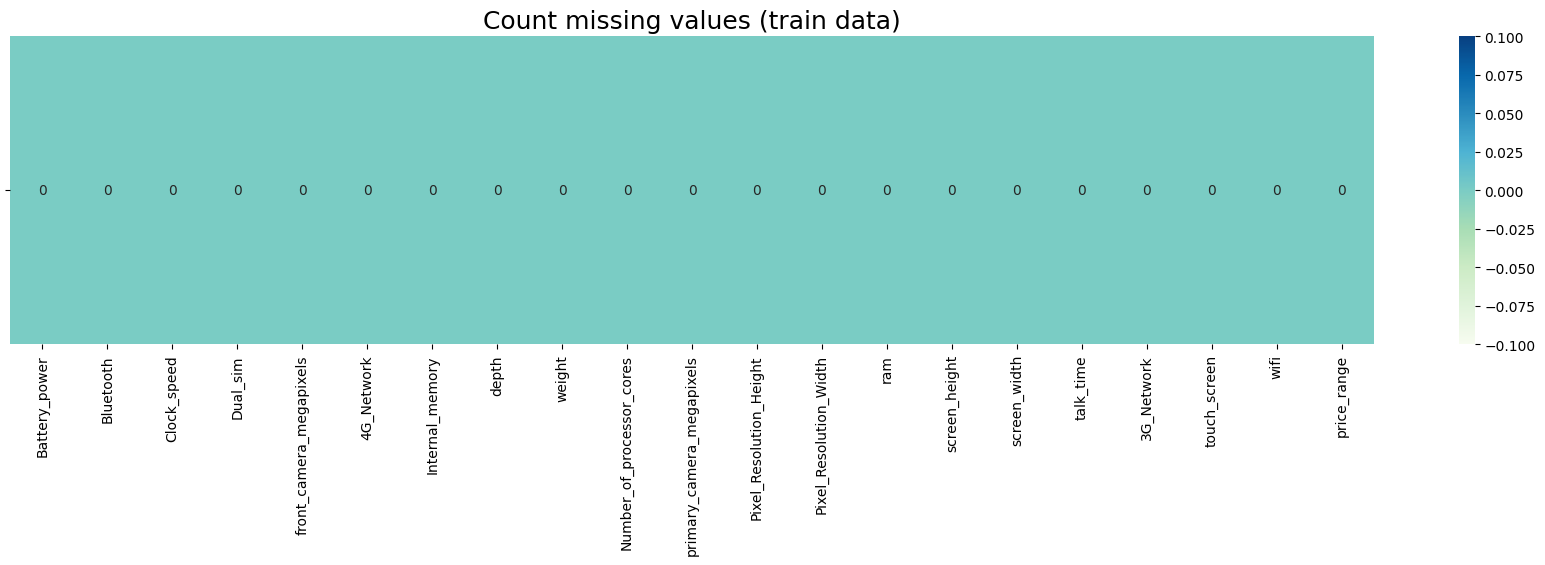

In [27]:
# Missing values (train)
plt.figure(figsize=(22,4))
sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Count missing values (train data)', fontsize=18)
plt.show()

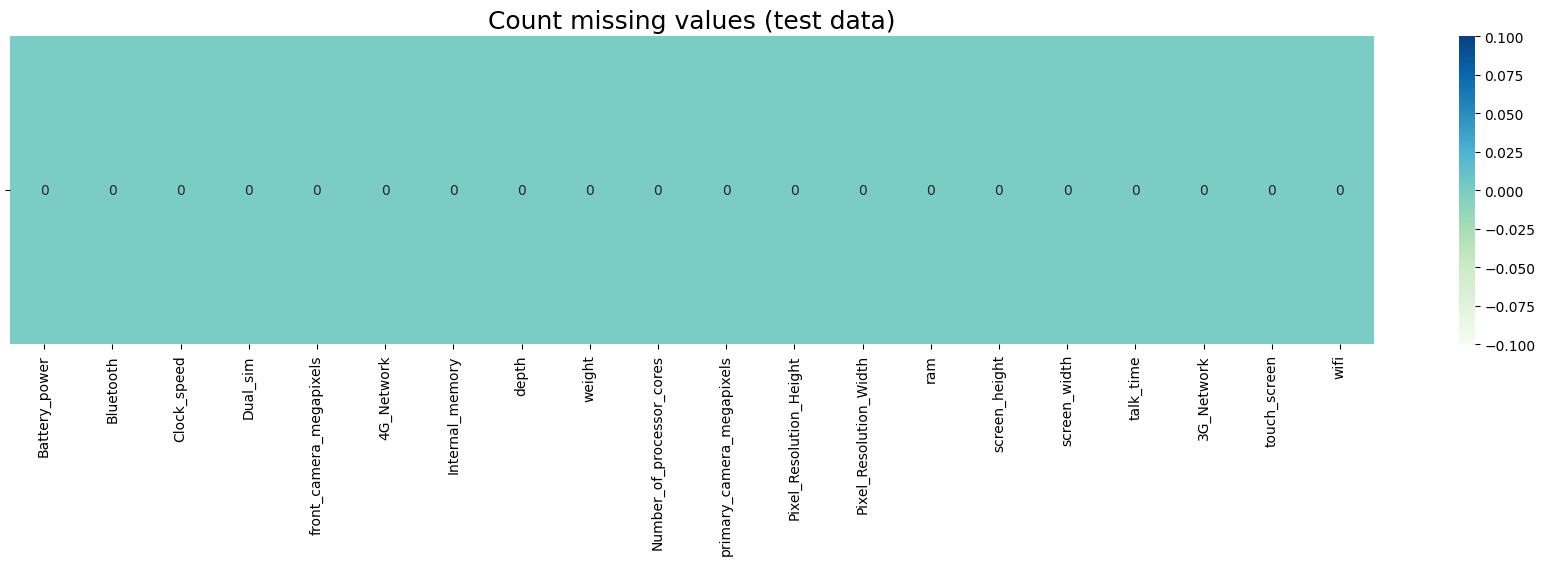

In [28]:
# Missing values (test)
plt.figure(figsize=(22,4))
sns.heatmap((df_test.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Count missing values (test data)', fontsize=18)
plt.show()

## Checking for the following:

*   Null Values
*   Duplicated Rows
*   Whitespaces within columns



In [29]:
#Checking for Null Values, Duplicated Rows and Whitespaces within columns
def check(case, df):
  if case == 'null':
    return df.isnull().sum()
  elif case == 'duplicate':
    return df.duplicated().sum()
  elif case == 'whitespace':
    return [ i for i in df.columns if i.startswith(' ') or i.endswith(' ')]   
  # elif case == 'outlier':
  #   q1 = df.quantile(0.25)
  #   q3 = df.quantile(0.75)
  #   iqr = q3 - q1
  #   lower_bound = q1 - 1.5*iqr 
  #   upper_bound = q3 + 1.5*iqr 
  #   print('Upper Bound Value : {}'. format(upper_bound),'\n')
  #   print('Lower Bound Value : {}'. format(lower_bound)) 


In [30]:
print(check('null', df))
check('duplicate', df)

Battery_power                0
Bluetooth                    0
Clock_speed                  0
Dual_sim                     0
front_camera_megapixels      0
4G_Network                   0
Internal_memory              0
depth                        0
weight                       0
Number_of_processor_cores    0
primary_camera_megapixels    0
Pixel_Resolution_Height      0
Pixel_Resolution_Width       0
ram                          0
screen_height                0
screen_width                 0
talk_time                    0
3G_Network                   0
touch_screen                 0
wifi                         0
price_range                  0
dtype: int64


0

In [31]:
check('whitespace', df)

[]

##OUTLIERS

In [33]:
# Separate numerical and categorical features
num_cols = pd.DataFrame (df, columns= ['Battery_power', 'Clock_speed', 'front_camera_megapixels', 'Internal_memory', 'depth', 'weight', 'primary_camera_megapixels', 'Pixel_Resolution_Height', 'Pixel_Resolution_Width', 'ram', 'screen_height', 'screen_width', 'talk_time'])
cat_cols = pd.DataFrame (df, columns= ['Bluetooth', 'Dual_sim', '4G_Network', 'Number_of_processor_cores', '3G_Network', 'touch_screen', 'wifi'])

In [34]:
# Separate numerical and categorical features into different lists
numerical_columns = list(df.loc[:,['Battery_power', 'Clock_speed', 'front_camera_megapixels', 'Internal_memory', 'depth', 'weight', 'primary_camera_megapixels', 'Pixel_Resolution_Height', 'Pixel_Resolution_Width', 'ram', 'screen_height', 'screen_width', 'talk_time']])
categorical_columns = list(df.loc[:,['Bluetooth', 'Dual_sim', '4G_Network', 'Number_of_processor_cores', '3G_Network', 'touch_screen', 'wifi']])

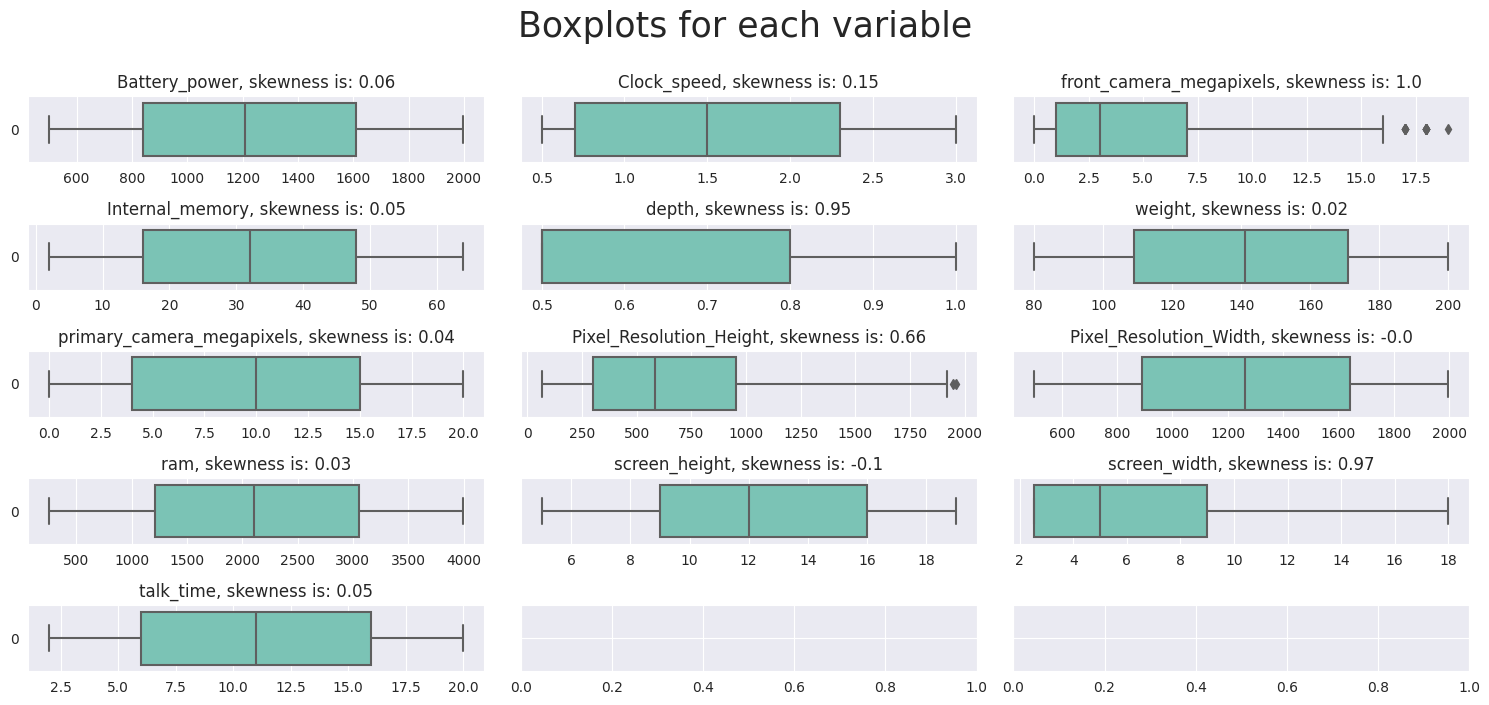

In [35]:
# Visualizing the Numerical Features by boxplots
sns.set_style('darkgrid')
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(15,7))
    fig.suptitle(suptitle, y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', color ='#6fcfbc', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True), 2)))
        
boxplots_custom(dataset=df, columns_list=num_cols, rows=5, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

##Detect Outliers

In [36]:
# Calculate the IQR for each column in the dataset
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using the IQR method
outliers = ((num_cols < (Q1 - 1.5 * IQR)) | (num_cols > (Q3 + 1.5 * IQR)))

# Count the number of outliers for each variable
num_outliers = outliers.sum()

# Number of outliers for each variable
num_outliers.to_frame().T

Battery_power  Clock_speed  front_camera_megapixels  Internal_memory  \
0              0            0                       16                0   

   depth  weight  primary_camera_megapixels  Pixel_Resolution_Height  \
0      0       0                          0                        2   

   Pixel_Resolution_Width  ram  screen_height  screen_width  talk_time  
0                       0    0              0             0          0

While the boxplots in the table above indicate the presence of outliers in the fc and px_height features, we cannot justify removing them from the dataset without a strong rationale to do so. Therefore, we have decided to retain these outliers in our analysis.

## Noises

Check for Noises

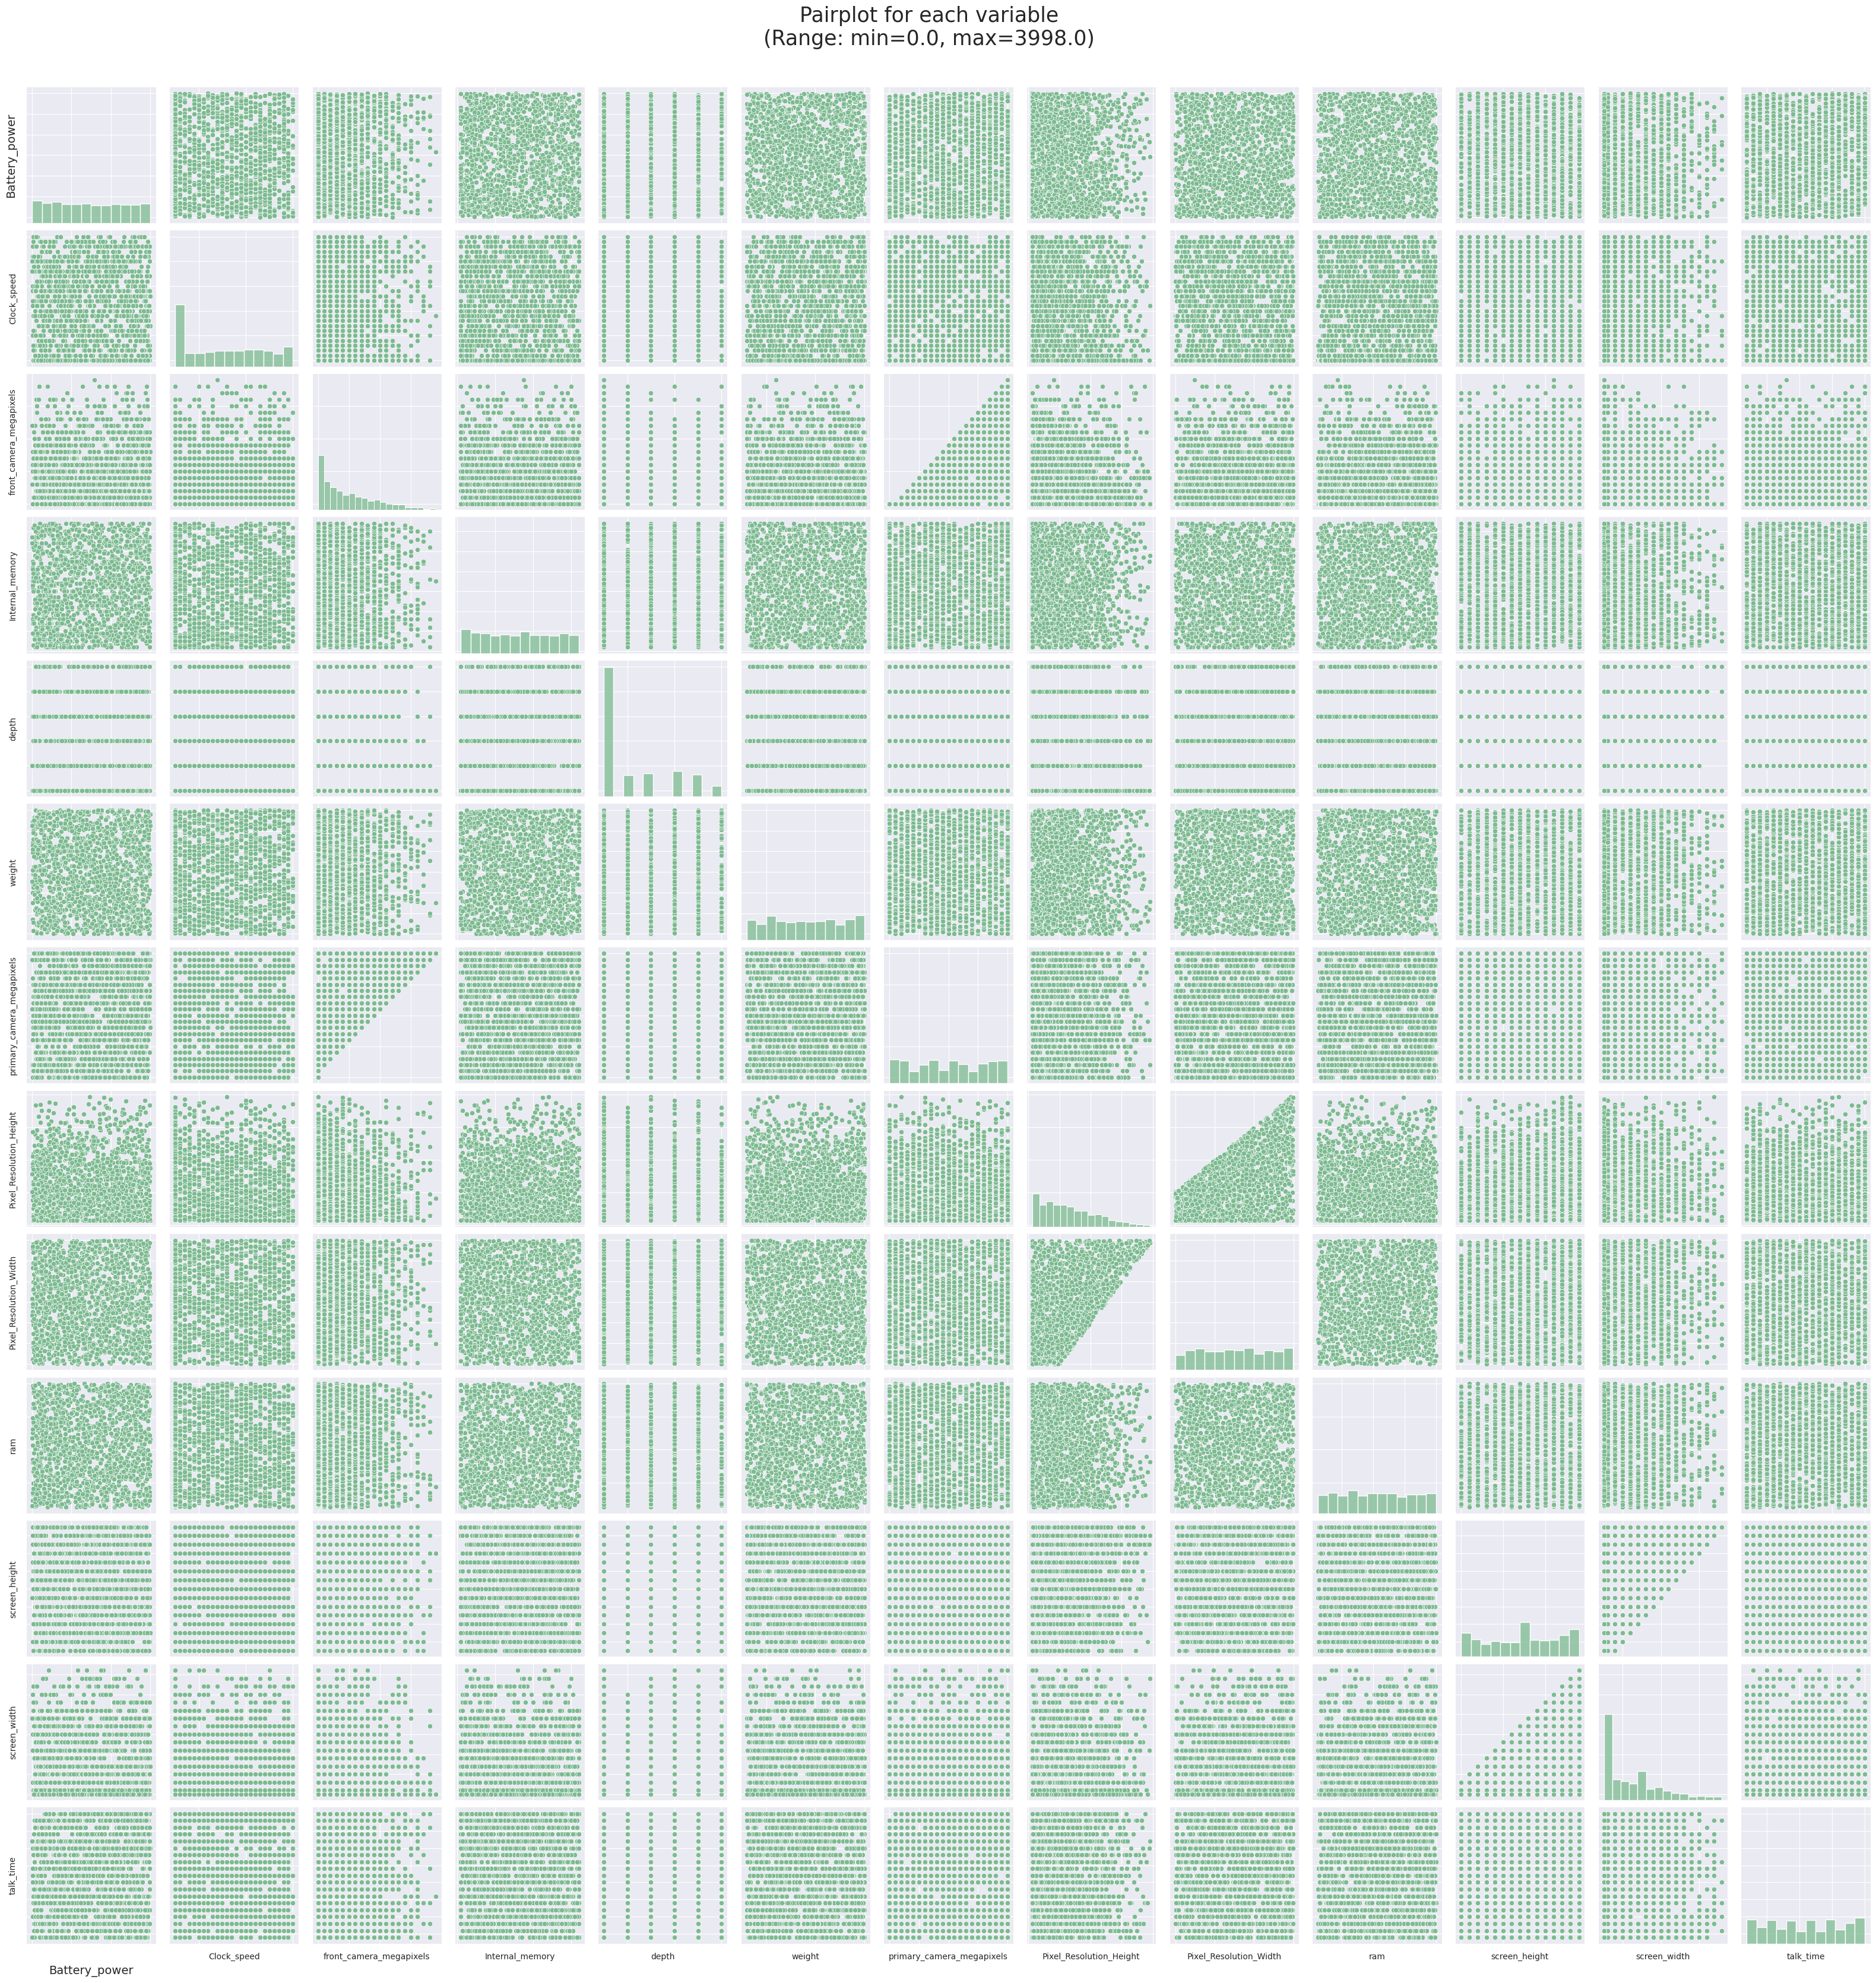

In [38]:
# Check noises by pairplot
sns.set_palette('crest')
sns.set_style('darkgrid')
dnp = sns.pairplot(df.loc[:, numerical_columns])

# Add axis labels and tick labels to the plot
dnp.set(xticklabels=[], yticklabels=[])
dnp.axes[0][0].set_ylabel(numerical_columns[0], fontsize=14)
dnp.axes[-1][0].set_xlabel(numerical_columns[0], fontsize=14)
dnp.axes[-1][0].xaxis.labelpad = 20
dnp.axes[-1][-1].yaxis.labelpad = 20

# Title of the plot
dnp.fig.suptitle('Pairplot for each variable\n(Range: min={}, max={})'.format(df[numerical_columns].min().min(), df[numerical_columns].max().max()), y=1.03, fontsize=25)

# Show the plot
plt.show()

#Exploratory Data Analysis (EDA)